# Create a Convolutional Neural Network using MNIST dataset
## Using PyTorch

In [1]:
import torch
import numpy as np

print('PyTorch version:', torch.__version__)
print('NumPy version: ', np.__version__)

PyTorch version: 2.3.0+cpu
NumPy version:  1.26.4


### Loading and preprocessing the data

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:07<00:00, 1281864.46it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 327748.09it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:06<00:00, 270633.11it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 1574293.76it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



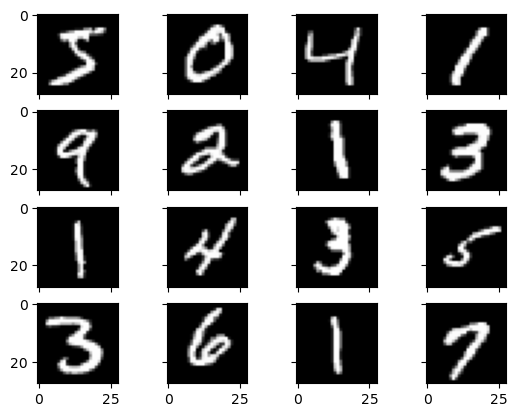

In [2]:
import matplotlib.pyplot as plt
import torchvision
 
train = torchvision.datasets.MNIST('./data', train=True, download=True)
 
fig, ax = plt.subplots(4, 4, sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(train.data[4*i+j], cmap="gray")
plt.show()

In [3]:
# Load MNIST data
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0,), (128,)),
])
train = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=1000)
testloader = torch.utils.data.DataLoader(test, shuffle=True, batch_size=1000)

### Constructing a CNN in PyTorch

In [4]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.dropout = nn.Dropout(0.2)
        self.flat = nn.Flatten()
        self.fc = nn.Linear(27*27*10, 128)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.relu1(self.conv(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.relu2(self.fc(self.flat(x)))
        x = self.output(x)
        return x
    
model = CNN()

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10
training_losses = []
validation_losses = []
validation_accuracies = []
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in trainloader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    training_losses.append(train_loss / len(trainloader))
    
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in testloader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
            correct += (torch.argmax(y_pred, 1) == y_batch).float().sum()
            total += y_batch.size(0)
    validation_losses.append(val_loss / len(testloader))
    validation_accuracies.append(correct / total)
    print(f'Epoch {epoch+1}: Train Loss: {train_loss / len(trainloader):.4f}, Validation Accuracy: {correct / total:.2f}')

torch.manual_seed(1)

Epoch 0: model val accuracy 11.91%
Epoch 1: model val accuracy 43.42%
Epoch 2: model val accuracy 70.86%
Epoch 3: model val accuracy 79.65%
Epoch 4: model val accuracy 83.57%
Epoch 5: model val accuracy 85.37%
Epoch 6: model val accuracy 87.06%
Epoch 7: model val accuracy 87.91%
Epoch 8: model val accuracy 88.39%
Epoch 9: model val accuracy 89.00%


In [7]:
#torch.cuda.synchronize()
model_cpu = model.cpu()
pred = model(test.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == test.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 

Test accuracy: 0.7132


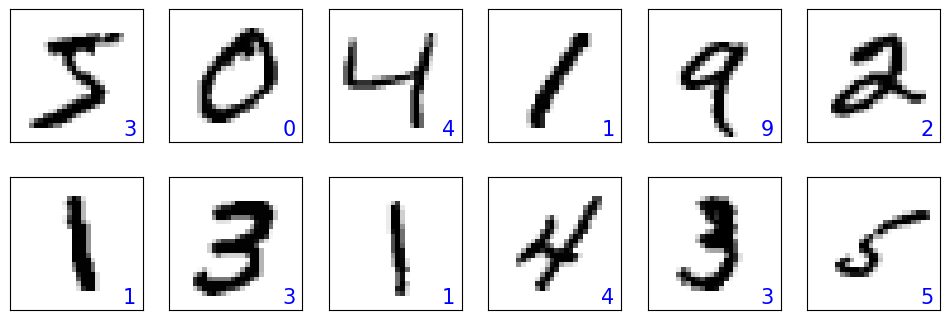

In [8]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = test[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1)) # alternatively: mnist_test_dataset.data[i].float()
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
#plt.savefig('figures/14_14.png')
plt.show()

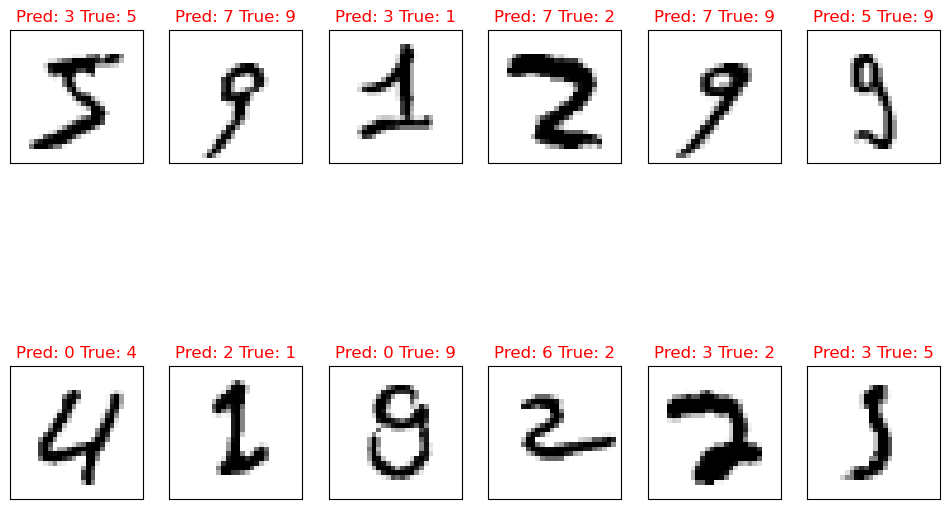

In [9]:
fig = plt.figure(figsize=(12, 8))
incorrect_count = 0

# Iterate over the test dataset
for i in range(len(test)):
    img, label = test[i][0], test[i][1]
    img = img.unsqueeze(0)  # Add batch dimension
    
    # Make prediction
    with torch.no_grad():
        pred = model(img)
    y_pred = torch.argmax(pred, dim=1).item()

    # Check if the prediction is incorrect
    if y_pred != label:
        incorrect_count += 1
        ax = fig.add_subplot(2, 6, incorrect_count)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(img.squeeze(), cmap='gray_r')  # Squeeze to remove batch dimension for plotting
        ax.set_title(f"Pred: {y_pred} True: {label}", color='red')
        
        # Display only a certain number of incorrect samples
        if incorrect_count == 12:
            break

if incorrect_count == 0:
    plt.close(fig)  # Close the figure if no incorrect predictions were found
    print("No incorrect predictions found.")
else:
    plt.show()

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'mnist_cnn.pth')